# Analytical estimation

In [1]:
using Analytical, Plots, Plots.PlotMeasures, ProgressMeter, BenchmarkTools

┌ Info: Precompiling Analytical [1f0a6972-6dc4-11ea-3a4f-47f17d9e5175]
└ @ Base loading.jl:1192
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
│   exception = Required dependency MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411] failed to load from a cache file.
└ @ Base loading.jl:969
┌ Info: Recompiling stale cache file /home/jmurga/.julia/compiled/v1.0/BenchmarkTools/ZXPQo.ji for BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1190


**Setting up model**

In [2]:
Analytical.changeParameters(gam_neg=-83,gL=10,gH=500,alLow=0.2,alTot=0.2,theta_f=1e-3,theta_mid_neutral=1e-3,al=0.184,be=0.000402,B=0.999,bRange=append!(collect(0.2:0.05:0.95),0.999),pposL=0.001,pposH=0.0,N=500,n=25,Lf=10^6,rho=0.001,TE=5.0,convoluteBinomial=true)

Dict{Float64,Array{Float64,2}} with 17 entries:
  0.95  => [1.0 0.948703 … 1.29963e-149 0.0; 0.0 0.0499844 … 6.16674e-145 0.0; …
  0.3   => [1.0 0.846246 … 1.39296e-124 0.0; 0.0 0.141513 … 2.08247e-120 0.0; ……
  0.45  => [1.0 0.894729 … 2.18461e-133 0.0; 0.0 0.0996357 … 4.90445e-129 0.0; …
  0.25  => [1.0 0.818402 … 1.26765e-120 0.0; 0.0 0.164338 … 1.57822e-116 0.0; ……
  0.35  => [1.0 0.866701 … 6.26034e-128 0.0; 0.0 0.124169 … 1.09243e-123 0.0; ……
  0.7   => [1.0 0.931015 … 5.5603e-143 0.0; 0.0 0.0665962 … 1.94332e-138 0.0; ……
  0.85  => [1.0 0.94284 … 3.38107e-147 0.0; 0.0 0.0555265 … 1.43526e-142 0.0; ……
  0.2   => [1.0 0.778313 … 8.88178e-116 0.0; 0.0 0.195556 … 8.83738e-112 0.0; ……
  0.9   => [1.0 0.94593 … 1.94033e-148 0.0; 0.0 0.0526101 … 8.72176e-144 0.0; ……
  0.65  => [1.0 0.925906 … 2.26116e-141 0.0; 0.0 0.0713333 … 7.33748e-137 0.0; …
  0.8   => [1.0 0.939376 … 7.00649e-146 0.0; 0.0 0.0587845 … 2.79909e-141 0.0; …
  0.5   => [1.0 0.904747 … 1.1259e-135 0.0; 0.0 0.090656 … 2.

Solving $\alpha_{(x)}$ to show asymptotic behaviour taking into account weakly benefical alleles

In [3]:
Analytical.set_theta_f()
theta_f = adap.theta_f
adap.B = 0.999
Analytical.set_theta_f()
Analytical.setPpos()
adap.theta_f = theta_f
adap.B= 0.999

x,y = Analytical.analyticalAlpha(gammaL=adap.gL,gammaH=adap.gH,pposL=adap.pposL,pposH=adap.pposH)

([-0.221219; -0.0986507; … ; 0.0619683; 0.0528265], [-0.203872; -0.079337; … ; 0.196603; 0.19785])

Plotting the results. $x$ contains $\alpha_{(x)}$ accounting for weakly beneficial alleles. $y$ contains the true value of $\alpha_{(x)}$, not accounting for weakly beneficial alleles.


In [ ]:
using Plots.PlotMeasures
gr()
Plots.theme(:wong)

Plots.plot(collect(1:size(x,1)),hcat(x,y),
    legend = :bottomright,
    seriestype = :line,
    xlabel = "Derived Alleles Counts",
    ylabel = "Alpha",
    label = ["All alleles" "Neutral + deleterious"],
    markershapes= [:circle :circle],
    linecolor=["#ee6677" "#4477aa"],
    markercolor=["#ee6677" "#4477aa"],
    lw = 1,
    xscale = :log,
    bottom_margin=10 * Plots.PlotMeasures.mm,
    left_margin=10 * Plots.PlotMeasures.mm,
    size=(800,500)
)

# Empirical case

In this example we provide a solution to replicate results at [Uricchio et al. 2019](https://doi.org/10.1038/s41559-019-0890-6). We will simulate $10^6$ summary statistics from random *DFE* to use as prior distribution in *ABCreg*. In this case we will need a set of empirical observed values in order to subset the summary statistics.

In [ ]:
Analytical.changeParameters(N=1000,n=661,convoluteBinomial=true)

Once the model account for the number of samples we can open the files. The function `Analytical.parseSfs` will return polymorphic and divergent counts and SFS accounting for the whole spectrum: `collect(1:adap.nn)/adap.nn`. In addition an output file will be created contained the observed values to input in *ABCreg*

In [47]:
path= "/home/jmurga/mktest/data/";suffix="txt";
files = path .* filter(x -> occursin(suffix,x), readdir(path))

empiricalValues = Analytical.parseSfs(data=files,output="data.tsv",sfsColumns=[3,5],divColumns=[6,7])

3-element Array{Array{Int64,N} where N,1}:
 [151646, 37604]                                
 [151646 37604; 34219 8190; … ; 302 67; 890 205]
 [73191, 17491]                                 

We make a function to perform $10^6$ simulated values. We solve the analytical approximation taking into account totally random and independent to draw *DFE* and $\alpha_{(x)}$. Each parameters combination are replicated to 5% frequency bins background selection values (saved at `adap.bRange`). 

In Julia you can easily parallelize a loop using ```$ export JULIA_NUM_THREADS=8```. Each iteration will be executed in a thread. In order to check the threads configured, just use in the julia console ```julia> Threads.nthreads()``` before the execution. We compute this example in a Intel i7-7700HQ (8) @ 3.800GHz laptop with 16GB of RAM using 8 threads. Please check [parallelization manual] in order to send the process in a multicore system (or just put two process manually with the *alphaSumStats.jl*, an script provided to launch from command line).

In [ ]:
using Base.Threads

In [74]:
function summStats(iter,data)
#@threads
    for i in 1:iter
        
        gam_neg=-rand(80:400)
        gL=rand(10:20)
        gH=rand(200:500)
        alLow=rand(collect(0.0:0.1:0.2))
        alTot=rand(collect(0.0:0.2:0.2))

        @threads for j in adap.bRange
            Analytical.changeParameters(gam_neg=gam_neg,gL=gL,gH=gH,alLow=alLow,alTot=alTot,theta_f=1e-3,theta_mid_neutral=1e-3,al=0.184,be=0.000402,B=j,bRange=adap.bRange,pposL=0.001,pposH=0.0,N=1000,n=661,Lf=10^6,rho,TE=5.0,convoluteBinomial=false)

            Analytical.set_theta_f()
            theta_f = adap.theta_f
            adap.B = 0.999
            Analytical.set_theta_f()
            Analytical.setPpos()
            adap.theta_f = theta_f
            adap.B = j

            x,y,z= Analytical.alphaByFrequencies(gammaL=adap.gL,gammaH=adap.gH,pposL=adap.pposL,pposH=adap.pposH,observedData=data)
            Analytical.summaryStatistics("/home/jmurga/prior.csv", z)
            
        end
    end
end

summStats (generic function with 1 method)

Required time to execute one solution (17 iterations, one per $B$ value). Times mostly depends on sample size.

In [75]:
@time summStats(58824,empiricalValues)

  229.469 ms (1123189 allocations: 145.95 MiB)


One random solution to summary statistics. Solving with two empirical subset.

In [72]:
gam_neg=-rand(80:400)
gL=rand(10:20)
gH=rand(100:500)
alLow=rand(collect(0.0:0.1:0.4))
alTot=rand(collect(0.1:0.1:0.4))

j = 0.999
Analytical.changeParameters(gam_neg=gam_neg,gL=gL,gH=gH,alLow=alLow,alTot=alTot,theta_f=1e-3,theta_mid_neutral=1e-3,al=0.184,be=0.000402,B=j,bRange=adap.bRange,pposL=0.001,pposH=0.0,N=1000,n=661,Lf=10^6,rho=0.001,TE=5.0,convoluteBinomial=false)

Analytical.set_theta_f()
theta_f = adap.theta_f
adap.B = 0.999
Analytical.set_theta_f()
Analytical.setPpos()
adap.theta_f = theta_f
adap.B = j

x,y,z= Analytical.alphaByFrequencies(gammaL=adap.gL,gammaH=adap.gH,pposL=adap.pposL,pposH=adap.pposH,observedData=empiricalValues)

([-0.237006 -0.244463; -0.091829 -0.0958624; … ; 0.0207804 0.0771764; 0.0182908 0.0818254], [-0.195463 -0.239028; -0.0443742 -0.0669554; … ; 0.310503 0.184775; 0.312542 0.184216], [37882.0 35144.0 … 0.294251 0.312542; 8947.0 8478.0 … 0.102391 0.184216])

Example of summary statistic values

In [76]:
z

2×27 Array{Float64,2}:
 37882.0  35144.0  153348.0  175982.0  …  0.0182908  0.294251  0.312542
  8947.0   8478.0   35279.0   41602.0     0.0818254  0.102391  0.184216

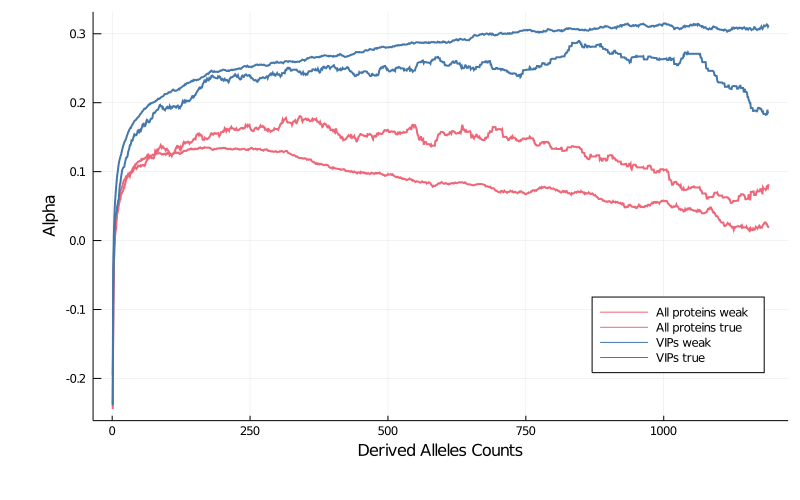

In [73]:
using Plots.PlotMeasures
gr()
Plots.theme(:wong)

Plots.plot(collect(1:size(x,1)),hcat(x,y),
    legend = :bottomright,
    seriestype = :line,
    xlabel = "Derived Alleles Counts",
    ylabel = L"\alpha",
    label = ["All proteins weak" "All proteins true" "VIPs weak" "VIPs true"],
    #markershapes= [:circle :circle :cross :cross],
    linecolor=["#ee6677" "#ee6677" "#4477aa" "#4477aa"],
    #markercolor=["#ee6677" "#4477aa"],
    lw = 2,
    #xscale = :log,
    bottom_margin=10 * Plots.PlotMeasures.mm,
    left_margin=10 * Plots.PlotMeasures.mm,
    size=(800,500)
)

Once we have the summary statistics we perform the *ABC* estimation.

# ABC inference

*ABCreg* will output one file per line in data. The files contain the posterior distributions. We return the posterior distributions, mean and quantiles.

In [37]:
posterior, result = Analytical.ABCreg(data="/home/jmurga/data.t",prior="/home/jmurga/tmp2.gz", nparams=7, nsummaries=4, outputPath="/home/jmurga/", outputPrefix="outPaper", tolerance=0.001, regressionMode="T",regPath="/home/jmurga/ABCreg/src/reg")

BoundsError: BoundsError: attempt to access 1273×7 Array{Float64,2} at index [Base.Slice(Base.OneTo(1273)), [25, 26, 27]]

In [38]:
posterior[1]

1059×27 Array{Float64,2}:
 8244.13  10719.3  35157.3  42367.6  …  1.96804   -0.0419507   0.821659
 8257.08  10415.0  35151.2  42792.7     1.73755   -0.0598708   0.684242
 8253.06  10539.1  34984.7  42652.9     1.71369   -0.00207514  0.837234
 8221.42  10676.2  35464.4  42592.3     1.72974   -0.0223541   0.797112
 8095.35  10726.9  34969.0  42496.5     2.07023   -0.120985    0.572689
 8301.47  10470.0  35121.1  42508.4  …  1.69851   -0.0223828   0.773959
 8070.3   10515.1  35211.9  42925.9     1.5855    -0.0285935   0.704621
 8316.14  10622.0  34788.2  42733.5     1.61949   -0.0127271   0.774269
 8157.92  10654.5  34802.8  42598.4     1.42964    0.0235849   0.823088
 8374.99  10575.0  35140.2  42341.1     0.632515   0.115616    0.755185
 8276.75  10637.2  35252.3  42750.2  …  1.12535    0.0367469   0.702886
 8221.95  10662.1  35187.6  42949.2     1.4069     0.0395616   0.816894
 8239.43  10390.2  34929.2  42422.8     2.30467   -0.178429    0.497618
    ⋮                                ⋱

You can easily plot the posterior distributions using Julia or just input the files at your favorite plot software.

In [9]:
using Plots.PlotMeasures, Plots, StatsPlots, LaTeXStrings

In [24]:
function plotPosterior(data,file,imgSize)

    Plots.gr()
    Plots.theme(:wong2)

    p1 = StatsPlots.density(data,
                            legend = :topleft,
                            fill=(0, 0.5),
                            #25, 52,
                            linecolor=["#00293C" "#1E656D" "#F62A00"],
                            fillcolor=["#00293C" "#1E656D" "#F62A00"],
                            xlabel = L"\alpha",
                            label = [L"\alpha_S" L"\alpha_W" L"\alpha"],
                            ylabel = "Posterior density",
                            lw = 1,
                            fmt = :svg,
                            size=imgSize
                        )
    Plots.savefig(file)

    return p1
    end;p = plotPosterior(posterior[1],"/home/jmurga/fig2.svg",(800,400))

plotPosterior (generic function with 1 method)

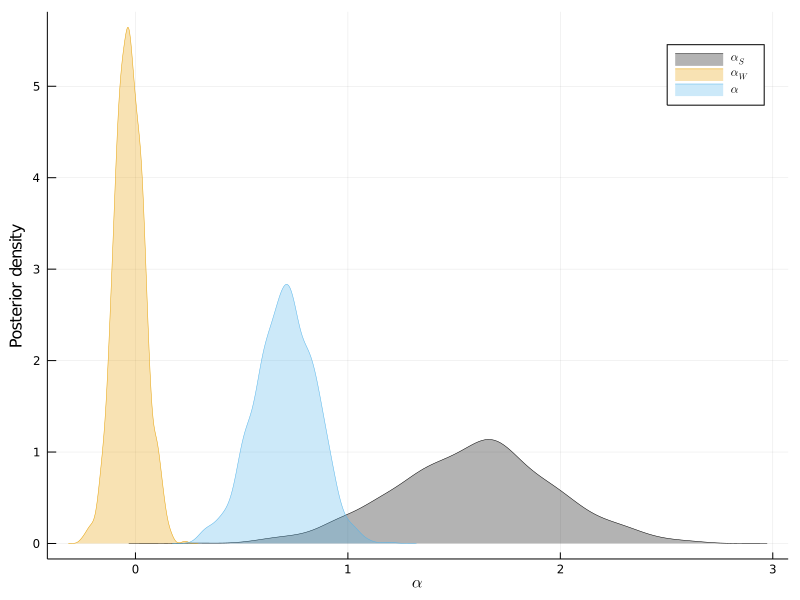

In [35]:
p = plotPosterior(posterior[1],"/home/jmurga/fig2.svg",(800,600))